# Project 1: Web scraping and basic summarization
*University of Ljubljana, Faculty for computer and information science* <br />
*Course: Introduction to data science*

In this Project you need to implement missing parts of this Jupyter notebook. All the code in the notebook must be reproducible and runnable, so include instructions for the environment setup or other specifics needed to run the notebook.

The idea of this Miniproject is to automatically retrieve structured data from pages [Stat.si](https://www.stat.si/Klasje/Klasje/Tabela/5531) and [eVem](http://evem.gov.si/info/skd-seznam/). 

## Environment setup

Write instructions how to setup the environment to run this notebook, which libraries are installed, etc. Also provide installation sources.

`TODO: environment setup description`

In [1]:
"""

#lines are commented so the user not to get error while running them in jupyter, they shall be run on anaconda - I use Windows
conda create --name web_scr
#press y as many times as needed same follows for the commands bellow will not type it anymore
conda activate web_scr
conda install -c anaconda ipykernelconda install nb_conda
#for big data
jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
# after this open new anaconda window 
# we can run using the commpand "jupyter notebook", but not the same abality to process data
#if not already navigated to the folder by using the cd command, go to the folder using jupyter 
#click kernel>change kernel> now pick the kernel associated with the environment ( this time conda-web_scr )

#packages back to anaconda just not in the window jupyter is running:
#run this command again:
conda activate web_scr

conda install -c conda-forge selenium
conda install beautifulsoup4
conda install pandas
conda install lxml
conda install html5lib
pip install html2text
#similar strings
conda install -c conda-forge jellyfish
#for plotting:
conda install matplotlib
#for connection graph
conda install networkx
conda install scipy
"""
#IMPORTANT NOTE: many libraries are loded in the cells and functions again ( they are the same ones) just in case this cell is not run and the program crushes, but still please run this cell
import jellyfish
import json
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
from pandas import DataFrame
from pandas.io.json import build_table_schema
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import lxml
from shutil import which
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
import networkx as nx
from scipy.cluster import hierarchy
import statistics 



## Web scraping

Standard Classification of Activities is a standardized list, which companies need to select to identify the activities of their business. You are expected to extract this hierarchical list along with the content from [eVem](http://evem.gov.si/info/skd-seznam/) and [Stat.si](https://www.stat.si/Klasje/Klasje/Tabela/5531). 

[Stat.si](https://www.stat.si/Klasje/Klasje/Tabela/5531) contains a flat list of activities, where you will find the Slovene and English version of the activity name. For extraction from this resource you can also download Excel and read data from it using a library (e.g. *openpyxl*).

[eVem](http://evem.gov.si/info/skd-seznam/) contains a hierarchical description of activities along with some descriptions - e.g. text, classified_also belongs_here, not_belongs_here, conditions, ...

<table>
    <tr>
        <td style="text-align: left;">eVem Web page example:</td>
        <td style="text-align: left;">Stat.si:</td>
    </tr>
    <tr>
        <td><img src="./eVem.png" /></td>
        <td><img src="./surs.png" /></td>
    </tr>
</table>

First define a hierarchical data schema and then implement parsing. Schema could look like as follows to be able to infer data types (the example should be representative):

```
[
  {
    "code": "I",
    "slv": "GOSTINSTVO",
    "eng": "ACCOMMODATION AND FOOD SERVICE ACTIVITIES",
    "activities": [
      ...,
      {
        "code": "I55",
        "slv": "Gostinske nastanitvene dejavnosti",
        "eng": "Accommodation",
        "activities": [
          ...,
          {
            "code": "I55.100",
            "slv": "Dejavnost hotelov in podobnih nastanitvenih obratov",
            "eng": "Hotels and similar accommodation",
            "text": "V ta podrazred spada nudenje ..."
            "belongs_here": [
              {
                "description": "dajanje nastanitvenih zmogljivosti v najem za krajši čas",
                "examples": ["v hotelih...", "v hotelskih ...", ...]
              },
              ...
            ],
            "not_belongs_here": [
              {
                "description": "dajanje nastanitvenih zmogljivosti v najem za daljši čas, mesečno ali letno",
                "code": "L68"
              },
              ...
            ],
            "classified_also": [
              "Dejavnost hotelov in podobnih ...",
              ...
            ],
            "conditions": "FULL TEXT - new lines preserved"
          },
          ...
        ]
      },
      ...
    ]
  }, 
  {
    ...
]
```

Schema could be defined also using [JSON Schema guidelines](https://json-schema.org/).

`TODO: definition and short description of JSON data schema of the extracted data.`

In the implementation below you can also import code from the accompanying *.py* files in the repository.

In [2]:
# Implement Stat.si page parsing

def parse_stat_si(url):
    import pandas as pd
    import time
    from selenium import webdriver
    from bs4 import BeautifulSoup
    import lxml
    from shutil import which
    from selenium.webdriver.common.keys import Keys
    from selenium.webdriver.chrome.options import Options
    from pandas import DataFrame
    from pandas.io.json import build_table_schema
    import json 

    #from sklearn import datasets 

    #url = 'https://www.stat.si/Klasje/Klasje/Tabela/5531'
    chrome_options=Options()
    chrome_options.add_argument("--headless")

    chrome_path=which("chromedriver")

    driver = webdriver.Chrome(executable_path=chrome_path,options=chrome_options)
    driver.get(url)
    time.sleep(3)
    html=driver.page_source
    soup=BeautifulSoup(html,'html.parser')
    table_find = soup.find('table',{'class':'TFtable'})
    table=pd.read_html(str(table_find))
    #schema=build_table_schema(table[0]) #if the schema is needed IMPORTANT!!
    #print(schema)
    
    result = table[0].to_json(orient="split")
    parsed = json.loads(result)
    json_string = json.dumps(parsed, ensure_ascii=False).encode('utf8')
    stat_data=json_string.decode()
    
    
    return stat_data

In [3]:
# Implement eVem page parsing 

def parse_eVem(url):
    #krajno proba za samo eden element da izvadam...
    import pandas as pd
    import time
    from selenium import webdriver
    from bs4 import BeautifulSoup
    import lxml
    from shutil import which
    from selenium.webdriver.common.keys import Keys
    from selenium.webdriver.chrome.options import Options
    from pandas import DataFrame
    from pandas.io.json import build_table_schema
    import json 
    #from sklearn import datasets 

    #url = 'http://evem.gov.si/info/skd-seznam/'
    chrome_options=Options()
    chrome_options.add_argument("--headless")

    chrome_path=which("chromedriver")

    driver = webdriver.Chrome(executable_path=chrome_path,options=chrome_options)
    driver.get(url)
    time.sleep(3)
    html=driver.page_source
    soup=BeautifulSoup(html,'html.parser')
    schema_evem={}
    title_schema= soup.find('h1',{'class':'title'})
    #print(title_schema.get_text())
    schema_evem["title"]=title_schema.get_text()
    schema_evem["data"]=[]
    schema_evem["only_titles"]=[]
    #schema_evem
    table_find = soup.find('ul',{'id':'skdul'})
    #obid za krajna finalna
    #cela so 2 titles 
    children=table_find.findChildren("li",recursive=False)# za prv naslov
    list_titles=[]

    for child in children:
        child11=child.findChild("a")
        schema_evem_ttl1={}
        schema_evem_ttl1["title"]=child11.text
        list_titles.append(child11.text)
        schema_evem_ttl1["data"]=[]
        child2find=child.find('ul',{'class':'expandablesskd expandables-complexskd'},recirsive=False)
        children2=child2find.findChildren("li",recursive=False)#za vtor naslov <li>
    
        for child2 in children2:
            child22=child2.findChild("a")
            schema_evem_ttl2={}
            schema_evem_ttl2["title"]=child22.text
            list_titles.append(child22.text)
            schema_evem_ttl2["data"]=[]
            child3find=child2.find('ul',{'class':'expandablesskd expandables-complexskd'})
            children3=child3find.findChildren("li",recursive=False)#za tret naslov <li>
            for child3 in children3:
                child33=child3.findChild("a")
                schema_evem_ttl3={}
                schema_evem_ttl3["title"]=child33.text
                soup3 = BeautifulSoup(str(child3))
                #schema_evem_ttl3["data"]={soup3.get_text()}# nadole e presmesteno... treba cela data u tava da ga stavam#posle treba da se smene u spada ne spada. . . 
                #za spaga e nadole
            
            
            
                #spagja

                #child=table_find.findChild("li")# za prv naslov

                #child11=child.findChild("a")

                #child2find=child.find('ul',{'class':'expandablesskd expandables-complexskd'})

                #child2=child2find.findChild("li")#za vtor naslov <li>

                #child22=child2.findChild("a")
                #child3find=child2.find('ul',{'class':'expandablesskd expandables-complexskd'})
                #child3=child3find.findChild("li")#za tret naslov <li>
                #child33=child3.findChild("a")
                #soup3 = BeautifulSoup(str(child3))
                details=soup3.find('div',{'class':'dataskd'})
                text=soup3.findChild('p',{'class':None})
                #print(text.text)
                detail_dict={}
                detail_dict["text"]=[]
                try:
                    detail_dict["text"]=text.text
                except:
                    pass
                detail_dict["belongs_here"]=[]
                detail_dict["not_belongs_here"]=[]
                detail_dict["conditions"]=[]

                soup4=BeautifulSoup(str(details))
                details_s_ns=soup4.findChildren("b")
                #print(details_s_ns)
                details_s_ns_el=soup4.findChild("ul")
                for c in details_s_ns:
                    #nov kod
                
                    s=""
                
                    try:
                        #print("c=",c)
                        s=str(c.text)
                        #print("s=",s)
                        s = s.split()
                        #print(s)
                        s= " ".join(s)
                        s=s.replace(':', '')
                    except:
                        pass
                
                
                    #print(s)
                    #s
                    if(s=="Sem spada"):
                        #print("inside sem spada")
                        details_s_ns_el=soup4.findChild("ul")
                        #nov kod
                        sp=""
                        try:
                            p=details_s_ns_el.findChild("li")
                            list_t=[]
                            sp=str(p.text)
                            try:
                                p.decompose()
                            except:
                                pass
                            sp = sp.split()
                            sp= " ".join(sp)
                            sp=sp.replace(':', '')
                        except:
                            pass
                        #print(sp)
                        det_dict={}
                        det_dict["descrtiption"]=sp
                        #print("dd",det_dict)
                        #det_dict["elements"]=[]
                        #nov kod (samo p u try e novo)
                        #p=details_s_ns_el.findChild("ul")
                        try:
                            p=details_s_ns_el.findChild("ul")
            
                            k=p.findChildren("span")
                            l_t=[]
                            for i in k:
                                try:
                                    l_t.append(i.text)
                                except:
                                    pass
                                
                            det_dict["elements"]=l_t
            
                            #print("ddd",det_dict)
                        except:
                            pass
            
                        detail_dict["belongs_here"]=det_dict
                        #print(detail_dict["belongs_here"])
                        #nov kod
                        try:
                            p.decompose()
                        except:
                            pass
    
                    elif(s=="Sem ne spada"):
                        #print("inside ne sem spada")
                        details_s_ns_el=soup4.findChild("ul")
                        #nov kod (p u try e staveno u nov kod)
                        list_t=[]
                         #nov kod
                
                        sp=""
                
                        try:
                            p=details_s_ns_el.findChild("li")
                            sp=str(p.text)
                            try:
                                p.decompose()
                            except:
                                pass
                            sp = sp.split()
                            sp= " ".join(sp)
                            sp=sp.replace(':', '')
                        except:
                            pass
                    
                        #print(sp)
                        det_dict={}
                        det_dict["descrtiption"]=sp
                        #det_dict["elements"]=[]
                        #nov kod (samo p u try e staveno)
                        try:
                            p=details_s_ns_el.findChild("ul")
                            k=p.findChildren("span")
                            l_t=[]
                            for i in k:
                                try:
                                    l_t.append(i.text)
                                except:
                                    pass
                                
                            det_dict["elements"]=l_t
                        except:
                            pass
        
                        detail_dict["not_belongs_here"]=det_dict
                        try:
                            p.decompose()
                        except:
                            pass
                
                    elif(s=="Pogoji"):
                        #print("inside Pogoji")
                        details_s_ns_el=soup4.findChild("ul")
                        p=details_s_ns_el.findChild("li")
                        list_t=[]
                        #nov kod
                
                        sp=""
                
                        try:
                            sp=str(p.text)
                            try:
                                p.decompose()
                            except:
                                pass
                            sp = sp.split()
                            sp= " ".join(sp)
                            sp=sp.replace(':', '')
                        except:
                            pass
                    
                        #print(sp)
                        det_dict={}
                        det_dict["descrtiption"]=sp
                        #det_dict["elements"]=[]
                        p=details_s_ns_el.findChild("ul")
                        try:
                            k=p.findChildren("span")
                            l_t=[]
                            for i in k:
                                try:
                                    l_t.append(i.text)
                                except:
                                    pass
                                
                            det_dict["elements"]=l_t
                            
                        except:
                            pass
        
                        detail_dict["conditions"]=det_dict
                        try:
                            p.decompose()
                        except:
                            pass
                #print("det",detail_dict)
                #za 2 titles e na dole
            
                schema_evem_ttl3["data"]=detail_dict
                list_temp=list(schema_evem_ttl2["data"])
                list_temp.append(schema_evem_ttl3)
                schema_evem_ttl2["data"]=list_temp
            
            list_temp=list(schema_evem_ttl1["data"])
            list_temp.append(schema_evem_ttl2)
            schema_evem_ttl1["data"]=list_temp
        #list_tempema_evem["data"]["data"]["data"]["title"]={child33.text}
        list_temp=list(schema_evem["data"])
        list_temp.append(schema_evem_ttl1)
        schema_evem["data"]=list_temp
    #print(schema_evem["title"],schema_evem["data"])
    #eVem_data=schema_evem["data"]
    schema_evem["only_titles"]=list_titles
    #json_object = json.dumps(schema_evem)   
    #print(json_object)
    #json_string = json.dumps(schema_evem, ensure_ascii=False).encode('utf8')
    #json_string = json.dumps(schema_evem["data"], ensure_ascii=False).encode('utf8')
    json_string = json.dumps(schema_evem, ensure_ascii=False).encode('utf8')
    #json_string
    eVem_data=json_string.decode()
    
    #json_string


    #def is_json(myjson):
      #try:
        #json_object = json.loads(myjson)
      #except ValueError as e:
        #return False
      #return True

    #print(is_json(json_string.decode()))
    return eVem_data

In [4]:
# Implement parsing, data merging and final representation

def parse_all(EVEM_URL,STAT_SI_URL):
    import json
    import jellyfish
    evemJ=parse_eVem(EVEM_URL)
    evemP= json.loads(evemJ)
    stat_siJ=parse_stat_si(STAT_SI_URL)
    stat_siP= json.loads(stat_siJ)
    diff={}
    ll=[]
    for i in stat_siP["data"]:
        c=0
        for j in evemP["only_titles"]:
            if(float(jellyfish.jaro_distance(i[2], j))>0.5):
                c=1    
        if(c==0):
            ll.append(i)
    
    data1=evemP
    if(ll!=[]): data1["different"]=ll
    #rint(data1)
    json_string = json.dumps(data1, ensure_ascii=False).encode('utf8')
    #json_string
    data=json_string.decode()
    #print(data)
    return data

In [5]:
# Main program and data export into a JSON
import json
EVEM_URL = "http://evem.gov.si/info/skd-seznam/"
STAT_SI_URL = "https://www.stat.si/Klasje/Klasje/Tabela/5531"

data = parse_all(EVEM_URL,STAT_SI_URL) #NOTE: the returned data is alreadz in the desired utf8 json format!
# Save data to UTF-8 encoded JSON
with open('data.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False)
# data is saved int encoded data.json file

## Basic summarization

Prepare and show at least five basic visualizations of the extracted data as presented in the chapter *Summarizing data - the basics* of the course's e-book. Explain each visualization of the data.

In [6]:
# Read data from JSON
import json
with open('data.json',encoding="utf8") as f:
    data2 = json.load(f)
#print(data2)
#Converting the data:
data22= json.loads(data2)
data = data22


### Visualization 1 - number of activities per category

`Calculates each activity per category and prints the total results, some categories are actually subcategories to the main ones. 
here are categories and subcategories so the way this task makes sense is to put each subcathegory as element of the cathegory
what i mean by this is if a category has 3 subcategories and those subcategories have 10 elements the main category will have sum of 30 elements and each sucathegory will have by 10 elements so the graph will make sence

 `

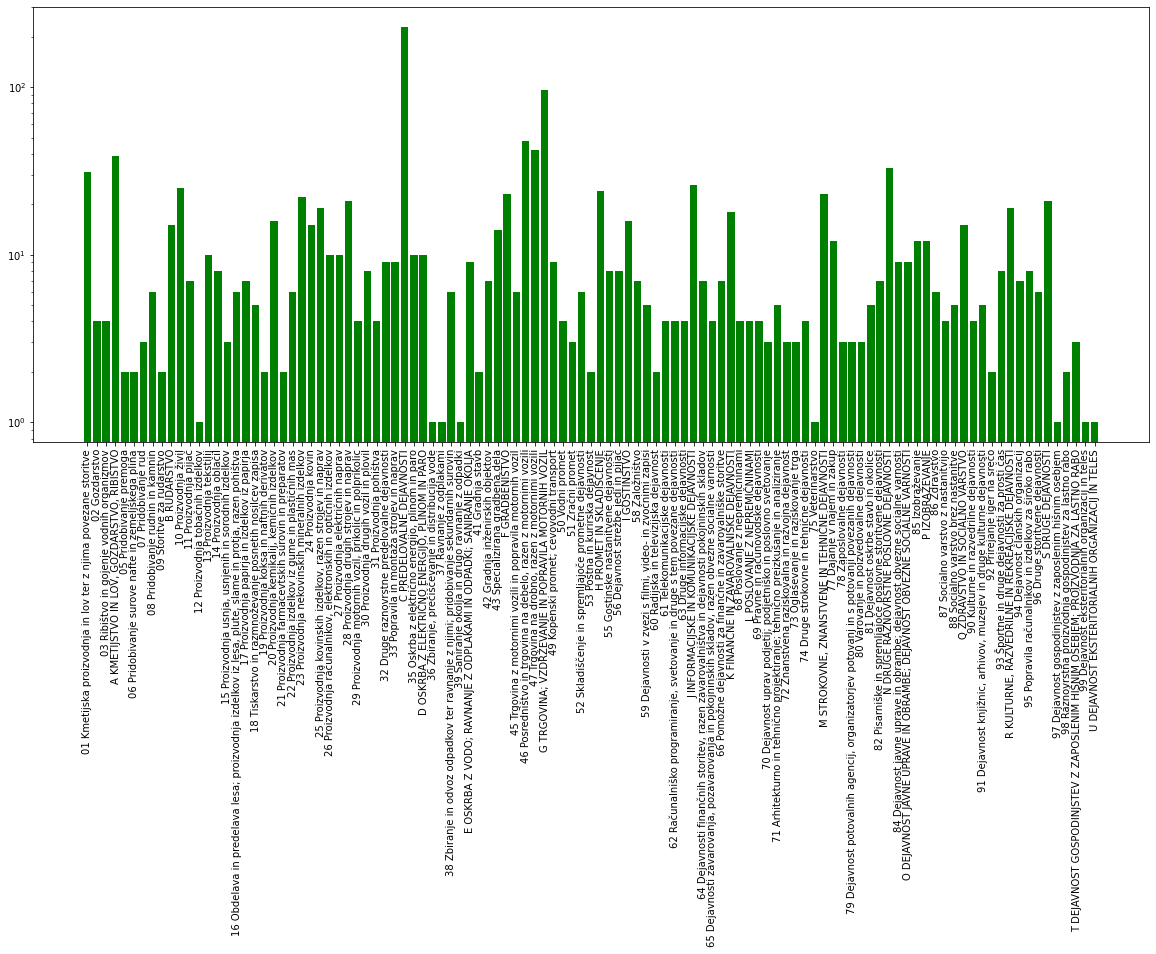

In [7]:
# Visualization 1 code
import numpy as np
import matplotlib.pyplot as plt
#print(data["data"][0]["data"][0]["data"][0])
dict_vis1={}
for i,ii in enumerate(data["data"]):
    ci=0
    for j,jj in enumerate(ii["data"]):
        cj=len(jj["data"])
        dict_vis1[jj["title"]]=len(jj["data"])
        ci=ci+cj
        #for k,kk in enumerate(jj["data"]):
            #ck=0
            #print(kk)
    dict_vis1[ii["title"]]=ci
#print(dict_vis1)
plt.figure(figsize=(20,8))
plt.yscale('log')
plt.bar(list(dict_vis1.keys()), dict_vis1.values(), color='g')
plt.xticks(rotation=90)
plt.show()


### Visualization 2 - connection graph based on *not belonging connections*

`Checks each non belonging item in the data but with using of jellyfish since not all words are exatly the same`

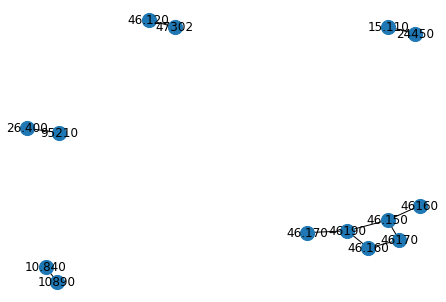

In [8]:
# Visualization 2 code
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

#treba da se mene malko kodo pokasno... treba not belongs da e lista... ne taka... za tava mi e greska u kodo izgleda
import numpy as np
import matplotlib.pyplot as plt
import jellyfish
import re
#print(data["data"][0]["data"][0]["data"][0])
not_belongs_here={}
dict_kk={}
dict_jj={}
list_kk=[]
for i,ii in enumerate(data["data"]):
    ci=0
    for j,jj in enumerate(ii["data"]):
        #cj=len(jj["data"])
        dict_vis1[jj["title"]]=len(jj["data"])
        #ci=ci+cj
        for k,kk in enumerate(jj["data"]):
            #ck=0
            #print(kk)
            c=kk["data"]
            dict_kk["title"]=kk["title"]
            dict_kk["data"]=kk["data"]
            list_kk.append(kk)
#print(dict_kk)
#print(list_kk[0]["data"]["not_belongs_here"]["descrtiption"])
list_1=[]
list_2=[]
listt_kk=[]
for i in range(len(list_kk)):
    listt_kk.append(list_kk[i]["data"]["not_belongs_here"])
#print(listt_kk[0]["descrtiption"])

#print(listt_kk)

listtt_kk=[]
for i in range(len(list_kk)-1):
    for j in range(i+1,len(list_kk)):
        try:
            if(jellyfish.jaro_distance(list_kk[i]["data"]["not_belongs_here"]["descrtiption"],list_kk[j]["data"]["not_belongs_here"]["descrtiption"] )>0.9):
                s1=list_kk[i]["title"]
                s1=s1[0:6]
                s1=re.sub('[A-Za-z]+', '', s1)
                list_1.append(s1)
                s2=list_kk[j]["title"]
                s2=s2[0:6]
                s2=re.sub('[^0-9]+', '', s2)
                list_2.append(s2)
        except:
            pass
#print(list_1)

#dict_kk["data"]
#for i,ii in list_kk:
    #print(list_kk[i])
    #dict_vis1[ii["title"]]=ci
#print(dict_vis1)


# Build a dataframe with 4 connections
df = pd.DataFrame({'from': list_1, 'to': list_2})

# Build your graph
G = nx.from_pandas_edgelist(df, 'from', 'to')

# Plot it
nx.draw(G, with_labels=True,node_size=200)
plt.figure(1,figsize=(20,20))
#plt.xticks(rotation=90)
plt.show()

### Visualization 3

`Titles similarity, how simillar are the Headers, headers are pretty much chasified by H1 and H2, so in H1 and H2 i use only the letter/number identifier they are unique, this may looks meaningless but as the graph shows we can pretty much determent what type of title/header the text  comes from`

<Figure size 432x288 with 0 Axes>

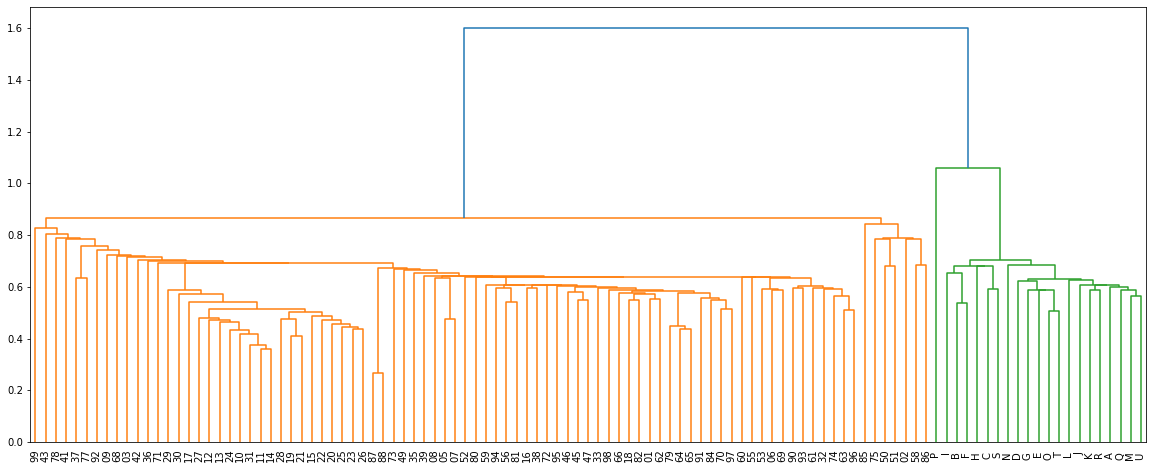

<Figure size 432x288 with 0 Axes>

In [9]:
# Visualization 3 code
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import jellyfish
import re
#print(data["data"][0]["data"][0]["data"][0])
not_belongs_here={}
dict_kk={}
dict_jj={}
list_kk=[]
title_list=[]

for i,ii in enumerate(data["data"]):
    title_list.append(ii["title"])
    for j,jj in enumerate(ii["data"]):
        title_list.append(jj["title"])
        #for k,kk in enumerate(jj["data"]):
            #title_list.append(kk["title"])
#print(len(title_list)) 
list_sim=np.zeros((len(title_list),len(title_list)),dtype=float)

for i in range(len(title_list)-1):
    for j in range(i,len(title_list)):
        s=jellyfish.jaro_distance(title_list[i],title_list[j])
        list_sim[i][j]=float(s)
        list_sim[j][i]=s
#print(list_sim)
ttl_list=[]
for i in range(len(title_list)):
    s=title_list[i]
    #print(s)
    s=s[0:2]
    #s=re.sub('[A-Za-z]+', '', s)
    ttl_list.append(s)
#print(ttl_list)
 
Z = hierarchy.linkage(list_sim, 'single')
plt.figure(figsize=(20,8))
dn = hierarchy.dendrogram(Z,labels=ttl_list, leaf_font_size=10, leaf_rotation=90)
plt.figure()

### Visualization 4

`variance of each class, counting how many elements each subclass has, calculation variance for each class as we have the number of the sublass and ploting those variances`

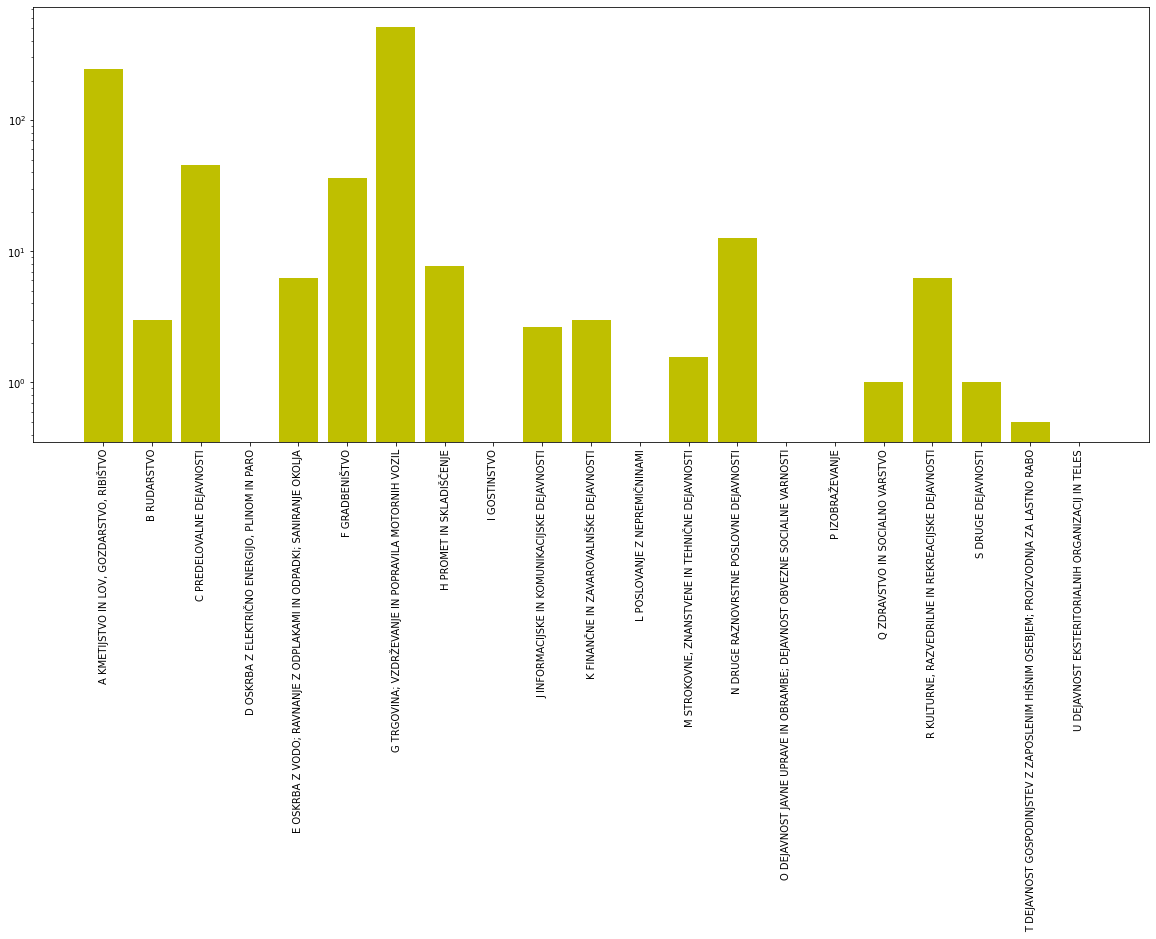

In [10]:
# Visualization 4 code
import numpy as np
import matplotlib.pyplot as plt
import jellyfish
import re
import statistics 
#print(data["data"][0]["data"][0]["data"][0])
not_belongs_here={}
dict_kk={}
dict_jj={}
list_kk=[]
title_list=[]
ssum=np.zeros(len(data["data"]),dtype=float)
avgg=np.zeros(len(data["data"]),dtype=float)
var=np.zeros(len(data["data"]),dtype=float)
ssum2=np.zeros(len(data["data"]),dtype=float)
#print(ssum)
dictt={}

for i,ii in enumerate(data["data"]):
    title_list.append(ii["title"])
    tmp=np.zeros(len(ii["data"]),dtype=float)
    for j,jj in enumerate(ii["data"]):
        tmp[j]=len(jj["data"]) 
    try:
        var[i]=float(statistics.variance(tmp))
    except:
        pass
    dictt[title_list[i]]=var[i]
#rint(var)


plt.figure(figsize=(20,8))
plt.yscale('log')
plt.bar(list(dictt.keys()), dictt.values(), color='y')
plt.xticks(rotation=90)
plt.show()


### Visualization 5

`Total data per category, see what category contains more data than others`

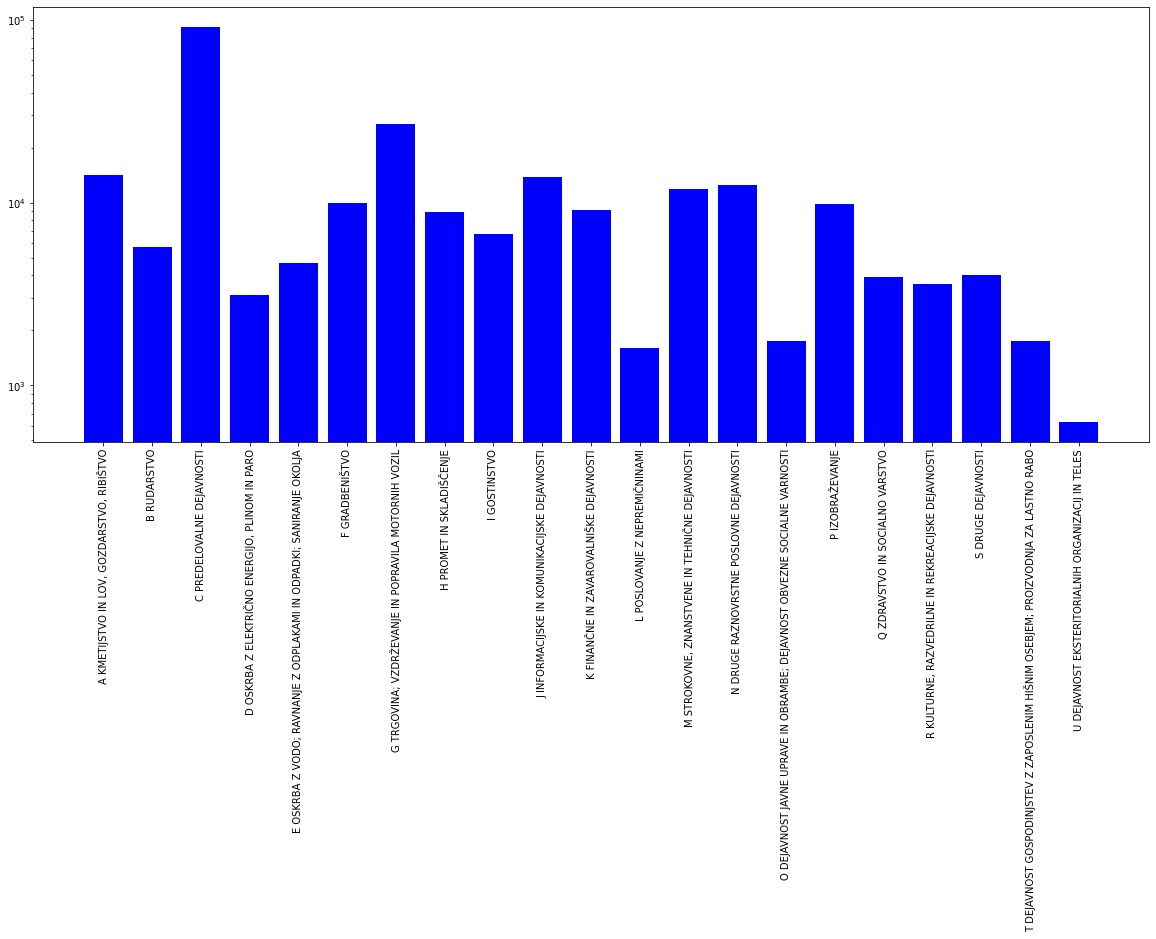

In [11]:
# Visualization 5 code

import numpy as np
import matplotlib.pyplot as plt
import jellyfish
import re


dictt={}
for i,ii in enumerate(data["data"]):
    dictt[ii["title"]]=len(str(ii["data"]))


plt.figure(figsize=(20,8))
plt.yscale('log')
plt.bar(list(dictt.keys()), dictt.values(), color='b')
plt.xticks(rotation=90)
plt.show()
